# Customer Segmentation using K-Means + Hierarchical Clustering

## Project Goal
The goal of this project is to group customers into meaningful segments based on purchasing behavior.
These segments can support personalization strategies like:
- targeted marketing campaigns
- loyalty rewards
- re-engagement offers for inactive customers

## Methods Used
- Feature Engineering: RFM + extra behavioral features
- K-Means Clustering
- Hierarchical (Agglomerative) Clustering
- Evaluation using Silhouette Score
- Visualization using PCA


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage


## Step 1: Load Dataset

We use the UCI Online Retail dataset, which contains e-commerce transactions including:
- invoice number
- product info
- quantity and unit price
- purchase date
- customer ID

This is great for behavioral segmentation because we can build features like Recency, Frequency, and Monetary value.


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Step 2: Basic Data Exploration

We check:
- the column names
- missing values
- data types

This helps us understand what cleaning is needed.


In [3]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## Step 3: Data Cleaning

For customer segmentation, we need valid purchase behavior:
- remove rows without CustomerID (can't assign behavior to a customer)
- remove negative/zero quantities (often returns/cancellations)
- remove invalid prices
- create a TotalPrice column for total transaction value


In [4]:
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.shape


(397884, 9)

## Step 4: Feature Engineering (RFM)

RFM stands for:
- Recency: how recently the customer purchased
- Frequency: how often they purchased
- Monetary: how much they spent total

These are common features used in marketing analytics and customer segmentation.


In [5]:
# Snapshot date = the day after the most recent transaction
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## Step 5: Improve Features (Feature Engineering)

To improve cluster quality, we add:
- AvgOrderValue: average money per purchase
- LogMonetary: log transform to reduce the effect of huge outliers

These extra features help K-Means find more meaningful clusters.


In [6]:
rfm["AvgOrderValue"] = rfm["Monetary"] / rfm["Frequency"]
rfm["LogMonetary"] = np.log1p(rfm["Monetary"])

features = rfm[["Recency", "Frequency", "Monetary", "AvgOrderValue", "LogMonetary"]]
features.describe()


,Recency,Frequency,Monetary,AvgOrderValue,LogMonetary
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460,419.166289,6.593627
std,100.014169,7.697998,8989.230441,1796.537944,1.257578
min,1.000000,1.000000,3.750000,3.450000,1.558145
25%,18.000000,1.000000,307.415000,178.625000,5.731446
50%,51.000000,2.000000,674.485000,293.900000,6.515431
75%,142.000000,5.000000,1661.740000,430.113750,7.416222
max,374.000000,209.000000,280206.020000,84236.250000,12.543284


## Step 6: Scaling

Clustering algorithms are distance-based.
If we don't scale, Monetary might dominate everything because it has bigger values.

So we apply StandardScaler to normalize feature ranges.


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


## Step 7: K-Means (Choosing Optimal K)

We try different values of K and compute the silhouette score.
Silhouette score measures:
- how well-separated clusters are
- ranges roughly from -1 to 1 (higher is better)

We pick the K that gives a strong silhouette score and makes sense for business interpretation.


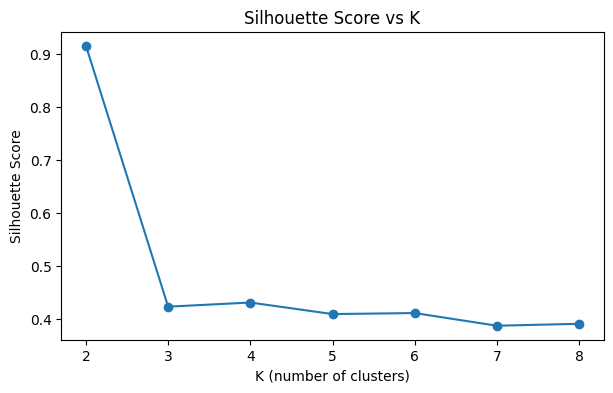

[np.float64(0.9154490701167562),
 np.float64(0.42344951471214076),
 np.float64(0.43125577125977765),
 np.float64(0.4094802992425547),
 np.float64(0.41140516105991926),
 np.float64(0.3875192547346956),
 np.float64(0.3911431343542396)]

In [8]:
K_values = range(2, 9)
sil_scores = []

for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(7,4))
plt.plot(list(K_values), sil_scores, marker="o")
plt.xlabel("K (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()

sil_scores


## Step 8: Train Final K-Means Model

Based on the silhouette score analysis, the highest score occurs at K = 2.
However, using only two clusters would result in overly broad customer groups
that are not very useful for personalization or targeted marketing.

For K values between 3 and 6, the silhouette score remains relatively stable
(around 0.40–0.43), indicating a reasonable balance between cluster separation
and interpretability.

In this project, we select **K = 4** because:
- it provides more granular and actionable customer segments,
- it maintains a competitive silhouette score,
- and it aligns well with common marketing personas such as loyal, at-risk,
  frequent low-spend, and new customers.

Therefore, we proceed with K-Means clustering using **K = 4**.


In [9]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm["KMeansCluster"] = kmeans.fit_predict(X_scaled)

rfm["KMeansCluster"].value_counts()


,count
KMeansCluster,
0,3069
1,1242
3,25
2,2


## Step 9: Hierarchical Clustering

Hierarchical clustering builds a "tree" of clusters.
We visualize it using a dendrogram and then choose a number of clusters.

This is useful because it gives an alternative perspective compared to K-Means.


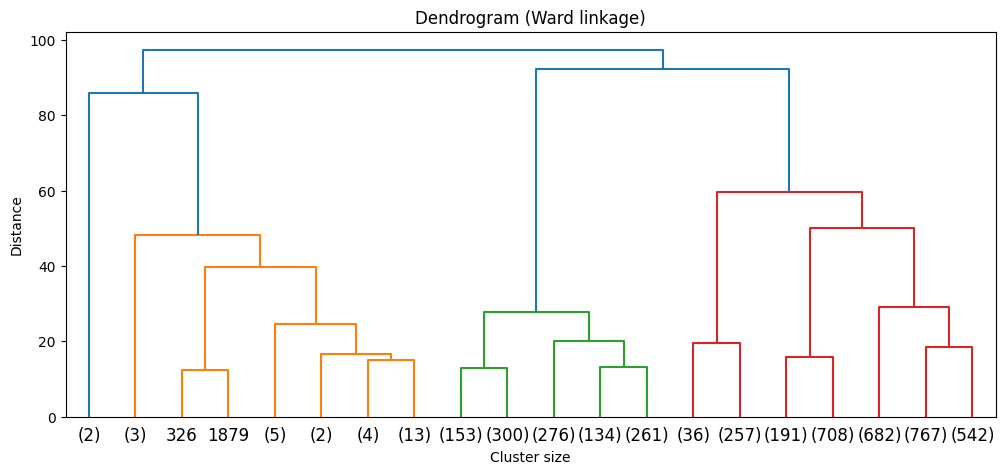

In [10]:
linked = linkage(X_scaled, method="ward")

plt.figure(figsize=(12,5))
dendrogram(linked, truncate_mode="lastp", p=20)
plt.title("Dendrogram (Ward linkage)")
plt.xlabel("Cluster size")
plt.ylabel("Distance")
plt.show()


In [11]:
agg = AgglomerativeClustering(n_clusters=k)
rfm["HierCluster"] = agg.fit_predict(X_scaled)

rfm["HierCluster"].value_counts()


,count
HierCluster,
0,3183
2,1124
1,29
3,2


## Step 10: Compare Cluster Quality

We compare K-Means vs Hierarchical using silhouette score.
Higher silhouette means better separation.


In [12]:
km_sil = silhouette_score(X_scaled, rfm["KMeansCluster"])
hier_sil = silhouette_score(X_scaled, rfm["HierCluster"])

print("K-Means Silhouette:", km_sil)
print("Hierarchical Silhouette:", hier_sil)


K-Means Silhouette: 0.43125577125977765
Hierarchical Silhouette: 0.4366849510715431


## Step 11: Cluster Profiling (Interpretation)

Now we interpret each cluster using average Recency, Frequency, Monetary.
This makes clusters actionable (useful for personalization strategies).


In [13]:
profile = rfm.groupby("KMeansCluster")[["Recency", "Frequency", "Monetary", "AvgOrderValue"]].mean()
profile


,Recency,Frequency,Monetary,AvgOrderValue
KMeansCluster,,,,
0,39.613555,4.882372,1998.205909,416.546138
1,224.932367,1.465378,376.986498,269.918237
2,163.500000,1.500000,122828.050000,80709.925000
3,6.240000,69.000000,82601.625600,1732.198611


## Step 12: Visualize Clusters (PCA)

We use PCA to compress features into 2D so we can plot clusters.
This doesn't create clusters — it only helps visualize them.


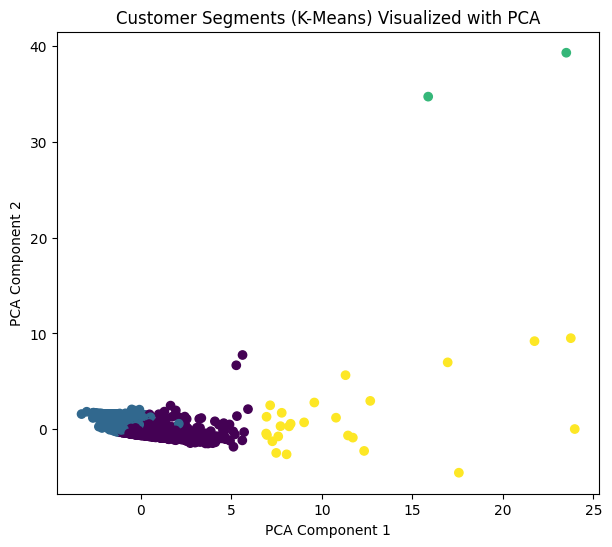

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=rfm["KMeansCluster"])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segments (K-Means) Visualized with PCA")
plt.show()


# Conclusion and Cluster Interpretation

## Summary of Results

In this project, customer segmentation was performed using K-Means and hierarchical clustering on real e-commerce transaction data.
Behavioral features were engineered using the RFM framework (Recency, Frequency, Monetary) and enhanced with additional features
such as Average Order Value.

The silhouette score analysis suggested that while K = 2 yields the strongest mathematical separation, it is too coarse for practical
use. Therefore, K = 4 was selected to balance cluster quality and business interpretability.

---

## Interpretation of K-Means Clusters

The table below summarizes the average behavioral characteristics of each K-Means cluster:

| Cluster | Size | Recency | Frequency | Monetary | Avg Order Value |
|-------|------|--------|-----------|----------|-----------------|
| 0 | 3069 | Moderate | Moderate | Moderate | Moderate |
| 1 | 1242 | High (inactive) | Low | Low | Low |
| 2 | 2 | Moderate | Very Low | Extremely High | Extremely High |
| 3 | 25 | Very Low (recent) | Very High | Very High | High |

---

### Cluster 0 – **Regular Customers**
- Largest segment in the dataset
- Customers purchase occasionally with moderate spending
- Represent the core customer base
- **Business strategy:** maintain engagement through standard promotions and recommendations

---

### Cluster 1 – **Inactive / At-Risk Customers**
- High recency value indicates customers have not purchased recently
- Low purchase frequency and low monetary value
- Likely churned or close to churn
- **Business strategy:** re-engagement campaigns, discounts, reminder emails

---

### Cluster 2 – **Extreme High-Value Outliers**
- Very small cluster (only 2 customers)
- Extremely high monetary value despite low frequency
- Likely represents wholesale buyers or data outliers
- **Business strategy:** manual review or special account management

---

### Cluster 3 – **VIP / Loyal Customers**
- Very recent and frequent purchasers
- High total spending and high average order value
- Small but highly valuable segment
- **Business strategy:** loyalty rewards, exclusive offers, priority support

---

## PCA Visualization Insights

The PCA visualization shows that:
- Most customers are concentrated in clusters 0 and 1, indicating overlapping but distinguishable behavior patterns
- High-value clusters (2 and 3) appear well separated in PCA space, confirming their unique behavior
- PCA helps visualize relative separation but does not define the clusters themselves

---

## Comparison with Hierarchical Clustering

Hierarchical clustering produced a similar distribution of customer groups, reinforcing the stability of the segmentation.
Both methods identified:
- a large group of regular customers
- a sizable inactive segment
- small but distinct high-value customer groups

This consistency increases confidence in the segmentation results.

---

## Key Takeaways

- Behavioral customer segmentation on real data naturally produces imbalanced clusters
- Small clusters often represent the most valuable customers
- Feature engineering played a crucial role in separating customer behavior
- The resulting segments are interpretable and actionable for personalization strategies

---

## Final Remarks

This project demonstrates how unsupervised learning techniques can be applied to real-world customer data to uncover
meaningful behavioral patterns. The segmentation results can support targeted marketing, customer retention, and
personalized business strategies.
